In [1]:
import os
from tqdm import tqdm
from glob import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, PredictionErrorDisplay
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso, RANSACRegressor
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline
from yellowbrick.regressor import PredictionError, residuals_plot
from feature_extraction import extract_features_from_images
from sklearn.cross_decomposition import PLSRegression

In [2]:
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
plt.style.use('ggplot')

In [3]:

def handle_model_evaluate(true, predicted, title_column=""):

    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2_square = r2_score(true, predicted)
    mape = np.mean(np.abs((true - predicted) / true)) * 100

    return pd.DataFrame(
        {
            f"{title_column}": [mae, mse, rmse, mape, r2_square],
        },
        index=["MAE", "MSE", "RMSE", "MAPE", "R-squared"],
    )

    
def show_model_performance(model, X_train, y_train, X_test, y_test):
    
    train = handle_model_evaluate(y_train, model.predict(X_train), "Treino")
    test  = handle_model_evaluate(y_test, model.predict(X_test), "Teste")
    
    display(pd.concat([train, test], axis=1))
    
    
def run_all_algs(X_train, y_train, X_test, y_test):

    models = {
        "GradientBoostingRegressor": GradientBoostingRegressor(),
        # "AdaBoostRegressor": AdaBoostRegressor(),
        "LinearRegression": LinearRegression(),
        "LassoRegression": Lasso(),
        "RidgeRegression": Ridge(),
        "RandomForestRegressor": RandomForestRegressor(),
        # "ElasticNet": ElasticNet(),
        # "[RANSACRegressor]": RANSACRegressor(),
        # "[PLSRegression]": PLSRegression(n_components=2),
        "PCARegression": make_pipeline(PCA(n_components=2), LinearRegression()),
        "PolyRegression": make_pipeline(PolynomialFeatures(degree=3), Lasso()),
        # "XGBRegressor": XGBRegressor()
    }
    
    for name, model in models.items():

        model.fit(X_train, y_train)
        
        print("\n","\b"+name)
        
        show_model_performance(model,
                               X_train,
                               y_train,
                               X_test,
                               y_test)

        print("_" * 20)
    
def print_evaluate(true, predicted, title_column=""):  
    
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2_square = r2_score(true, predicted)
    mape = np.mean(np.abs((true - predicted) / true)) * 100
    
    print(pd.DataFrame({
        f"{title_column}": [
            mae, 
            mse, 
            rmse,
            mape,
            r2_square],
    },
        index=[
            "MAE",
            "MSE",
            "RMSE",
            "MAPE",
            "R-squared"
        ]))

    
def ApplyesKFoldV2(x, y, k=5):
    metrics = [
        "r2",
        "neg_mean_absolute_error",
        "neg_mean_squared_error",
        "neg_root_mean_squared_error",
        "neg_mean_absolute_percentage_error"    
    ]
    
    kfold  = KFold(n_splits=k, shuffle=True, random_state=0)

    models = {
        "GradientBoostingRegressor": GradientBoostingRegressor(),
        # "AdaBoostRegressor": AdaBoostRegressor(),
        "LinearRegression": LinearRegression(),
        "LassoRegression": Lasso(),
        "RidgeRegression": Ridge(),
        "RandomForestRegressor": RandomForestRegressor(),
        # "ElasticNet": ElasticNet(),
        # "RANSACRegressor": RANSACRegressor(),
        # "PLSRegression": PLSRegression(n_components=2),
        "PCARegression": make_pipeline(PCA(n_components=2), LinearRegression()),
        "PolyRegression": make_pipeline(PolynomialFeatures(degree=2), Lasso()),
    }

    results = {}
    
    for name, model in models.items():
        results[name] = cross_validate(model, x, y, cv=kfold, scoring=metrics)
        
    for name, cv_results in results.items():
        print(f"[{name}]")
        display(pd.DataFrame({
            f"Média": [
                cv_results['test_r2'].mean(), 
                -cv_results['test_neg_mean_absolute_error'].mean(),
                -cv_results['test_neg_mean_squared_error'].mean(),
                -cv_results['test_neg_root_mean_squared_error'].mean(),
                -cv_results['test_neg_mean_absolute_percentage_error'].mean()
            ],
            "Desvio Padrão": [
                cv_results['test_r2'].std(),
                cv_results['test_neg_mean_absolute_error'].std(),
                cv_results['test_neg_mean_squared_error'].std(),
                cv_results['test_neg_root_mean_squared_error'].std(),
                cv_results['test_neg_mean_absolute_percentage_error'].std()
            ]
        },
            index=["R-squared", "MAE", "MSE", "RMSE", "MAPE"],
        ))


def apply_pca_reduce(data, n=None):
    
    scaler = StandardScaler()
    X = scaler.fit_transform(data)
    
    pca = PCA(n_components=data.shape[-1]).fit(X)
    
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    dim = np.argmax(cumsum >= 0.90) + 1
    
    print('Para preservar 90% da variance é necessário ' + str(dim))
        
    pca_refit = PCA(n_components=n if n else dim).fit(X)
    print('Ratio: ', pca_refit.explained_variance_ratio_)
    
    return pca_refit.transform(X)

def corr_view(df, w=8, h=6):
    corrmat = df.corr()

    _, ax = plt.subplots(figsize=(w, h))

    sns.heatmap(corrmat, linewidths=5, annot=True);
    
    plt.show()
    
    return corrmat

## Extraindo Features das imagens mascaras

In [4]:
def load_dataset(base_path):
    
    *_, base_path_last = base_path.split("/")
    features_file_name = f"{base_path_last}_features.csv"
    
    if not os.path.isfile(features_file_name):
        extract_features_from_images(
            images_arr=[],
            images_path=f"{base_path}/masks",
            output_file_name=features_file_name,
            resize_shape=(224, 224))
    
    weights = pd.read_csv(f"{base_path}/annotations.csv")
    features = pd.read_csv(features_file_name)

    weights.index = weights.img
    features.index = features.label

    weights = weights.drop('img', axis=1)
    features = features.drop('label', axis=1)
    
    data = pd.concat([weights, features],
                     axis=1,
                     ignore_index=False, 
                     verify_integrity=True)

    data = data.reset_index()
    
    return data



In [5]:
data = load_dataset("data/coletas/combined")

In [6]:
data.specie.value_counts()

tambaqui    148
tilápia      61
curimatã     20
panga         8
traíra        5
lambari       3
Name: specie, dtype: int64

In [7]:
f"{data.weight.sum() // 1000} " + "kg"

'105.0 kg'

In [8]:
# data.weight /= 1000

In [9]:
enc = LabelEncoder()

In [10]:
data.specie = enc.fit_transform(data.specie.values)

In [11]:
def load_unet_dataset(df):
    
    weights = df[["weight", "length", "specie", "width"]]
    weights.index = df["index"]

    features_file_name = "features_from_unet_predictions.csv"
    features = pd.read_csv(features_file_name)
    
    features.index = features.label

    features = features.drop('label', axis=1)
    
    data = pd.concat([weights, features],
                     axis=1,
                     ignore_index=False, 
                     verify_integrity=True)

    data = data.reset_index()
    
    return data

### Ajustando Features Extraídas da U-net

In [12]:
_, X_test = train_test_split(data, test_size=0.3, random_state=0)
unet_testing_features = load_unet_dataset(X_test)

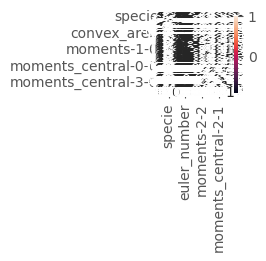

In [13]:
corrmat = corr_view(data, w=1, h=1)

In [14]:
features_names = list(dict(corrmat[corrmat.weight > 0.85].weight).keys())
features_names.append("specie")

In [15]:
data[features_names].head()

,weight,length,area,bbox_area,convex_area,equivalent_diameter,filled_area,major_axis_length,moments-0-0,moments-0-1,...,moments-2-1,moments-2-2,moments-2-3,moments_central-0-0,moments_central-0-2,moments_central-2-0,moments_central-2-2,perimeter,feret_diameter_max,specie
0,220.0,22.0,5867,8908,6372,86.429719,5867,122.598160,5867.0,344885.0,...,4.695134e+08,3.385144e+10,2.780223e+12,5867.0,5.510758e+06,1.470126e+06,7.711683e+08,340.048773,132.230859,3
1,545.0,26.0,10098,15272,10689,113.389474,10098,154.971729,10098.0,818043.0,...,2.222528e+09,2.201669e+11,2.427110e+13,10098.0,1.513501e+07,4.568750e+06,3.687127e+09,438.374675,166.364059,4
2,1025.0,31.0,13583,20580,14173,131.508223,13583,180.579492,13583.0,1285297.0,...,3.716828e+09,4.027404e+11,4.892637e+13,13583.0,2.755749e+07,8.335128e+06,9.660429e+09,500.114790,196.918765,0
3,740.0,37.0,8521,12864,9204,104.159849,8521,183.209467,8521.0,791315.0,...,1.111224e+09,1.270943e+11,1.647843e+13,8521.0,1.787565e+07,1.987899e+06,2.195729e+09,459.948268,192.210822,2
4,475.0,24.0,8184,11907,8614,102.079344,8184,138.020198,8184.0,587517.0,...,1.239091e+09,1.098955e+11,1.083366e+13,8184.0,9.715353e+06,3.038349e+06,2.008774e+09,380.776695,147.275253,4


In [16]:
unet_testing_features = unet_testing_features[features_names]

In [17]:
y = data.weight
X = data[features_names].drop(labels=['weight'], axis=1)
l = data['index']

In [18]:
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(X.values, 
                                                                             y.values,
                                                                             l.values.tolist(),
                                                                             test_size=0.3, 
                                                                             random_state=0)

Unet_y_test = unet_testing_features.weight
unet_testing_features = unet_testing_features[features_names].drop(labels=['weight'], axis=1)

In [19]:
len(X_train), len(X_test)

(171, 74)

In [20]:
scaler = StandardScaler()

X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)
Unet_X_test_scaled = scaler.transform(unet_testing_features.values)

# Features Normalizadas

In [21]:
run_all_algs(X_train_scaled, 
             y_train,
             X_test_scaled,
             y_test)


GradientBoostingRegressor


,Treino,Teste
MAE,5.753149,34.080842
MSE,53.400895,6913.339257
RMSE,7.307592,83.146493
MAPE,6.286146,7.738139
R-squared,0.999181,0.881033


____________________

LinearRegression


,Treino,Teste
MAE,23.975293,41.857285
MSE,962.880039,8170.421887
RMSE,31.030308,90.390386
MAPE,37.311182,13.513414
R-squared,0.985241,0.859400


____________________

LassoRegression


,Treino,Teste
MAE,31.956953,46.104884
MSE,1804.489268,9151.278810
RMSE,42.479280,95.662317
MAPE,21.587117,14.614081
R-squared,0.972340,0.842521


____________________

RidgeRegression


,Treino,Teste
MAE,28.597508,42.378959
MSE,1448.371179,8878.617778
RMSE,38.057472,94.226418
MAPE,15.823772,13.928071
R-squared,0.977799,0.847213


____________________

RandomForestRegressor


,Treino,Teste
MAE,11.722678,34.963216
MSE,444.830216,6880.521693
RMSE,21.090998,82.948910
MAPE,41.852797,7.590665
R-squared,0.993182,0.881597


____________________

PCARegression


,Treino,Teste
MAE,37.241035,50.885100
MSE,2470.607808,9959.732323
RMSE,49.705209,99.798459
MAPE,92.887716,15.452599
R-squared,0.962130,0.828609


____________________

PolyRegression


,Treino,Teste
MAE,19.584782,44.523812
MSE,622.533633,11046.601860
RMSE,24.950624,105.102816
MAPE,28.739563,18.416496
R-squared,0.990458,0.809906


____________________


# Features Não Normalizadas

In [22]:
run_all_algs(X_train, 
             y_train,
             X_test,
             y_test)


GradientBoostingRegressor


,Treino,Teste
MAE,5.753149,33.900804
MSE,53.400895,6887.236139
RMSE,7.307592,82.989374
MAPE,6.286146,7.606488
R-squared,0.999181,0.881482


____________________

LinearRegression


,Treino,Teste
MAE,23.974582,41.854334
MSE,962.880129,8170.057059
RMSE,31.030310,90.388368
MAPE,37.276645,13.512083
R-squared,0.985241,0.859406


____________________

LassoRegression


,Treino,Teste
MAE,26.431473,39.656571
MSE,1171.437241,8451.399781
RMSE,34.226265,91.931495
MAPE,27.699546,13.043333
R-squared,0.982044,0.854565


____________________

RidgeRegression


,Treino,Teste
MAE,23.950637,41.683038
MSE,962.984248,8140.760631
RMSE,31.031987,90.226164
MAPE,36.381970,13.413555
R-squared,0.985239,0.859911


____________________

RandomForestRegressor


,Treino,Teste
MAE,11.574877,36.681784
MSE,398.139804,7158.794449
RMSE,19.953441,84.609659
MAPE,30.578551,8.370187
R-squared,0.993897,0.876809


____________________

PCARegression


,Treino,Teste
MAE,53.294235,69.551406
MSE,5604.668222,13437.109407
RMSE,74.864332,115.918546
MAPE,249.648657,22.293332
R-squared,0.914090,0.768769


____________________

PolyRegression


,Treino,Teste
MAE,14.071769,31.924466
MSE,324.874632,5085.567821
RMSE,18.024279,71.313167
MAPE,20.140633,7.897775
R-squared,0.995020,0.912486


____________________


# Prevendo para as máscaras geradas pela a unet - Sem normalização

In [23]:
run_all_algs(X_train, 
             y_train,
             unet_testing_features.values,
             y_test)


GradientBoostingRegressor


,Treino,Teste
MAE,5.753149,41.883434
MSE,53.400895,7405.489313
RMSE,7.307592,86.055153
MAPE,6.286146,10.472568
R-squared,0.999181,0.872563


____________________

LinearRegression


,Treino,Teste
MAE,23.974582,59.531243
MSE,962.880129,9437.620208
RMSE,31.030310,97.147415
MAPE,37.276645,19.039013
R-squared,0.985241,0.837594


____________________

LassoRegression


,Treino,Teste
MAE,26.431473,57.662196
MSE,1171.437241,9605.645580
RMSE,34.226265,98.008395
MAPE,27.699546,18.401953
R-squared,0.982044,0.834702


____________________

RidgeRegression


,Treino,Teste
MAE,23.950637,59.496301
MSE,962.984248,9414.481077
RMSE,31.031987,97.028249
MAPE,36.381970,18.984062
R-squared,0.985239,0.837992


____________________

RandomForestRegressor


,Treino,Teste
MAE,11.003918,43.362838
MSE,330.879983,7778.158405
RMSE,18.190107,88.193868
MAPE,34.847223,10.396883
R-squared,0.994928,0.866150


____________________

PCARegression


,Treino,Teste
MAE,53.294235,70.666161
MSE,5604.668222,13343.222121
RMSE,74.864332,115.512866
MAPE,249.648657,23.037587
R-squared,0.914090,0.770385


____________________

PolyRegression


,Treino,Teste
MAE,14.071769,40.712081
MSE,324.874632,5728.659042
RMSE,18.024279,75.687906
MAPE,20.140633,10.664158
R-squared,0.995020,0.901419


____________________


# Prevendo os pesos para as márcas previstas pela unet | Normalizado

In [24]:
run_all_algs(X_train_scaled, 
             y_train,
             Unet_X_test_scaled,
             y_test)


GradientBoostingRegressor


,Treino,Teste
MAE,5.753149,41.296664
MSE,53.400895,7347.096177
RMSE,7.307592,85.715204
MAPE,6.286146,10.406900
R-squared,0.999181,0.873568


____________________

LinearRegression


,Treino,Teste
MAE,23.975293,59.529593
MSE,962.880039,9437.755647
RMSE,31.030308,97.148112
MAPE,37.311182,19.038821
R-squared,0.985241,0.837591


____________________

LassoRegression


,Treino,Teste
MAE,31.956953,55.031958
MSE,1804.489268,8736.306219
RMSE,42.479280,93.468210
MAPE,21.587117,17.528081
R-squared,0.972340,0.849662


____________________

RidgeRegression


,Treino,Teste
MAE,28.597508,55.451863
MSE,1448.371179,8942.838852
RMSE,38.057472,94.566584
MAPE,15.823772,17.916019
R-squared,0.977799,0.846108


____________________

RandomForestRegressor


,Treino,Teste
MAE,11.733789,43.153730
MSE,407.688055,7759.390649
RMSE,20.191287,88.087403
MAPE,38.297140,10.327579
R-squared,0.993751,0.866473


____________________

PCARegression


,Treino,Teste
MAE,37.241035,54.234824
MSE,2470.607808,9209.688890
RMSE,49.705209,95.967124
MAPE,92.887716,17.147199
R-squared,0.962130,0.841516


____________________

PolyRegression


,Treino,Teste
MAE,19.584782,49.269408
MSE,622.533633,10944.823711
RMSE,24.950624,104.617511
MAPE,28.739563,19.989758
R-squared,0.990458,0.811657


____________________


# KFold Base Completa

In [25]:
ApplyesKFoldV2(X.values, y.values, k=10)

[GradientBoostingRegressor]


,Média,Desvio Padrão
R-squared,0.948509,0.046907
MAE,30.191133,13.422909
MSE,4231.828935,5360.343515
RMSE,53.645025,36.797285
MAPE,0.431264,1.102556


[LinearRegression]


,Média,Desvio Padrão
R-squared,0.916003,0.067720
MAE,38.634638,19.924548
MSE,7165.200820,8997.645655
RMSE,69.881547,47.767878
MAPE,0.403067,0.975666


[LassoRegression]


,Média,Desvio Padrão
R-squared,0.948340,0.052341
MAE,33.058583,12.211045
MSE,3806.849370,5773.404311
RMSE,51.553907,33.897552
MAPE,0.599363,1.556591


[RidgeRegression]


,Média,Desvio Padrão
R-squared,0.916283,0.067658
MAE,38.586087,19.928811
MSE,7142.836878,8983.591178
RMSE,69.750226,47.725704
MAPE,0.399285,0.964782


[RandomForestRegressor]


,Média,Desvio Padrão
R-squared,0.945702,0.044853
MAE,31.876821,13.012178
MSE,4243.634894,5243.925198
RMSE,54.939476,35.004126
MAPE,0.512901,1.338996


[PCARegression]


,Média,Desvio Padrão
R-squared,0.863217,0.063852
MAE,59.450182,16.137315
MSE,8314.969495,8029.216407
RMSE,84.182258,35.047352
MAPE,1.735975,4.667051


[PolyRegression]


,Média,Desvio Padrão
R-squared,0.926055,0.049774
MAE,34.117808,13.069283
MSE,5110.334955,5444.705029
RMSE,62.247616,35.150665
MAPE,0.377524,0.920124


# PCA + Kfold Base Completa

In [26]:
X_pca = apply_pca_reduce(X.values, 2)

ApplyesKFoldV2(X_pca, y.values, k=10)

Para preservar 90% da variance é necessário 2
Ratio:  [0.89758847 0.0477517 ]
[GradientBoostingRegressor]


,Média,Desvio Padrão
R-squared,0.927278,0.042374
MAE,41.510625,15.080491
MSE,4957.346326,5501.620498
RMSE,62.034263,33.303100
MAPE,0.515546,1.273078


[LinearRegression]


,Média,Desvio Padrão
R-squared,0.919737,0.059523
MAE,42.418198,15.129838
MSE,5634.693078,7179.097503
RMSE,64.748453,37.978031
MAPE,0.218223,0.299254


[LassoRegression]


,Média,Desvio Padrão
R-squared,0.920902,0.058866
MAE,42.300635,14.984307
MSE,5514.065433,7039.656405
RMSE,64.209033,37.299672
MAPE,0.264461,0.439303


[RidgeRegression]


,Média,Desvio Padrão
R-squared,0.919794,0.059497
MAE,42.410597,15.118030
MSE,5629.132130,7173.181825
RMSE,64.722452,37.949128
MAPE,0.218863,0.301357


[RandomForestRegressor]


,Média,Desvio Padrão
R-squared,0.930707,0.037181
MAE,40.617042,14.757823
MSE,4774.936163,4981.120872
RMSE,61.544826,31.419271
MAPE,0.504724,1.246319


[PCARegression]


,Média,Desvio Padrão
R-squared,0.919737,0.059523
MAE,42.418198,15.129838
MSE,5634.693078,7179.097503
RMSE,64.748453,37.978031
MAPE,0.218223,0.299254


[PolyRegression]


,Média,Desvio Padrão
R-squared,0.799249,0.402122
MAE,47.659149,31.904285
MSE,20897.591240,49456.644469
RMSE,92.247541,111.301314
MAPE,0.195444,0.306810


## Polinomial Features -  Qualquer  regressor pode ser adicionado ao pipeline

#### Obs: Não executar transformação de features


Foi selecionado um dos modelos de regressão que performaram bem para visualizar dua predições

In [44]:
model = make_pipeline(PolynomialFeatures(degree=3), Lasso(0.5)).fit(X_train, y_train)

print_evaluate(y_train, model.predict(X_train), "Treino")
print_evaluate(y_test, model.predict(X_test), "Teste")

               Treino
MAE         14.051310
MSE        324.694800
RMSE        18.019290
MAPE        21.042099
R-squared    0.995023
                 Teste
MAE          32.486902
MSE        5132.968023
RMSE         71.644735
MAPE          8.406508
R-squared     0.911670


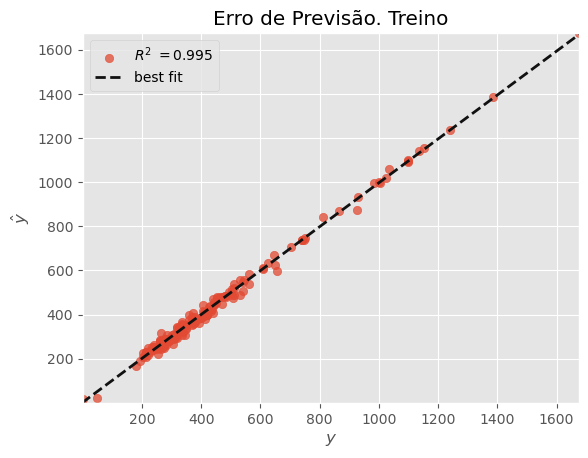

In [28]:
visualizer = PredictionError(model)
visualizer.score(X_train, y_train)
visualizer.title = "Erro de Previsão. Treino"
visualizer.shared_limits = False
visualizer.identity = False
visualizer.show();

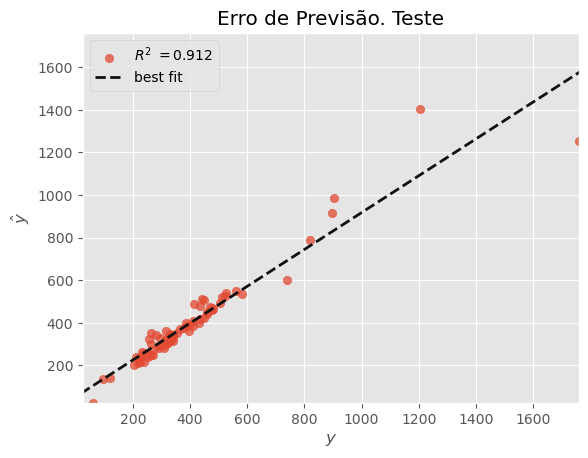

In [29]:
visualizer = PredictionError(model)
visualizer.score(X_test, y_test)
visualizer.title = "Erro de Previsão. Teste"
visualizer.shared_limits = False
visualizer.identity = False
visualizer.show();

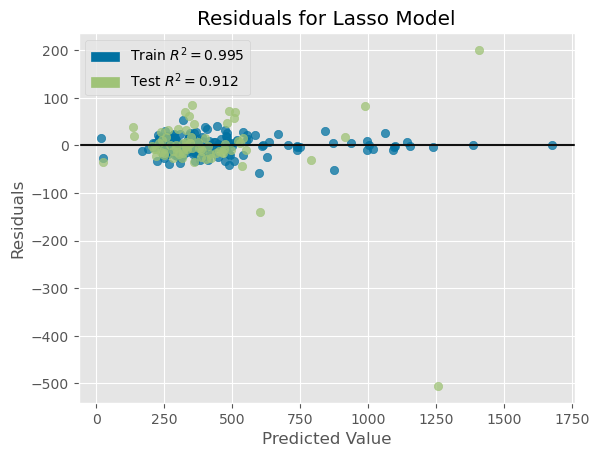

In [30]:
viz = residuals_plot(model, 
                     X_train, 
                     y_train, 
                     X_test, 
                     y_test,
                     hist=False)

viz.show()
plt.show();